In [1]:
%pylab inline
%config InlineBackend.figure_format = 'svg'
%load_ext cython
%load_ext memory_profiler

Populating the interactive namespace from numpy and matplotlib


# Strava segment recommender

In [2]:
import pandas as pd
import stravalib
from mpl_toolkits.basemap import Basemap

## Get data from Strava Public API

In [3]:
client = stravalib.Client(access_token='ea571a903a95d27a567aadfaeb85d8e76aeafee3')

### Get IDs of popular Bay Area segments

`Client.explore_segments` is limited to returning only 10 (of the most popular) segments per request. To get the most popular segments over a large area of the map, we can place a grid on the desired map area and make a request for each square of the grid.

In [4]:
# lat/lon bounds for the whole region of interest (South SF Bay Area)
bounds = dict(llcrnrlat=36.8, llcrnrlon=-122.6, 
              urcrnrlat=38.0, urcrnrlon=-121.6)

Now, define the grid...

In [5]:
gridlines = 15 # number of grid lines to use
gridlat = linspace(bounds['llcrnrlat'], bounds['urcrnrlat'], gridlines)
gridlon = linspace(bounds['llcrnrlon'], bounds['urcrnrlon'], gridlines)

# TODO: heatmap

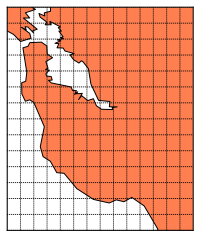

In [6]:
mp = Basemap(resolution='i', **bounds)
mp.fillcontinents(color='coral', lake_color='aqua')
mp.drawcoastlines()
mp.drawparallels(gridlat)
mp.drawmeridians(gridlon);

In [7]:
gridsquares = [(south, west, north, east)
               for (south, north) in zip(gridlat[:-1], gridlat[1:])
               for (west, east) in zip(gridlon[:-1], gridlon[1:])]

In [ ]:
segment_ids = [segment.id 
               for gridsquare in gridsquares
               for segment in client.explore_segments(gridsquare)]

In [11]:
segment_ids

array([4236635,  658876, 5086842, ..., 9087160, 8931176, 2453178])

In [10]:
#savetxt('segment_ids.txt', segment_ids, fmt='%d')
segment_ids = loadtxt('segment_ids.txt', dtype=int)

### Get segment leaderboards

In [ ]:
leaderboards = [client.get_segment_leaderboard(segment_id, top_results_limit=100) 
                for segment_id in segment_ids]

In [158]:
len(leaderboards)

1494

In [91]:
columns = ['activity_id','athlete_id','average_hr',
           'average_watts','effort_id','elapsed_time',
           'moving_time','rank','start_date']

In [241]:
def leaderboard_to_df(leaderboard, fields):

    records = [[entry.__getattribute__(x) for x in fields]
               for entry in leaderboard]
    
    df = pd.DataFrame.from_records(records, columns=fields)
    return df.convert_objects().set_index('athlete_id')

In [253]:
leaders = [leaderboard_to_df(lb, columns) for lb in leaderboards]
leaders = pd.concat(leaders, keys=segment_ids, names=['segment_id'])

In [255]:
leaders.head()

activity_id  average_hr  average_watts   effort_id  \
segment_id athlete_id                                                       
4236635    486181          8285355         NaN            NaN  1042926966   
           28074          50693803         NaN          324.4  1042851213   
           161275         51255641       166.0          310.3  1042851956   
           65625          50698083       175.9          316.7  1042851236   
           5402           50743918       169.3          299.0  1042851269   

                       elapsed_time  moving_time  rank          start_date  
segment_id athlete_id                                                       
4236635    486181          00:10:40     00:10:40     1 2012-04-26 21:56:32  
           28074           00:10:41     00:10:41     2 2013-04-25 17:58:12  
           161275          00:10:41     00:10:41     2 2013-04-25 17:58:14  
           65625           00:10:42     00:10:42     4 2013-04-25 17:58:12  
           5402            00:10:43     00:10:43     5 2013-04-25 17:58:12

In [3]:
#leaders.to_hdf('leaders.h5', 'leaders')
leaders = pd.read_hdf('leaders.h5', 'leaders')

In [4]:
leaders['rank'].head()

segment_id  athlete_id
98          241840        1
            637337        2
            31292         3
            8777          4
            1689588       5
Name: rank, dtype: float64

In [5]:
rating = (leaders['rank'].groupby(level='segment_id')
                         .transform(lambda x: 1 + (x-1)/(max(x)-1)))

In [ ]:
Y = rating.unstack().values
mu = nanmean(Y, axis=0) # mean normalization
Y -= mu
R = (~isnan(Y)).astype(np.int32)
Y = where(isnan(Y), 0, Y)
segment_id = df.index.get_level_values('segment_id').unique()
athlete_id = df.index.get_level_values('athlete_id').unique()

In [274]:
Y.shape

(1475, 20234)

In [275]:
R.shape

(1475, 20234)

# Collaborative filtering

In [276]:
from scipy.optimize import fmin_cg

In [277]:
num_features = 100             # analogout to action, comedy, romance, etc.
num_athletes = len(athlete_id) # analogous to users
num_segments = len(segment_id) # analogous to movies

In [311]:
def roll_params(X, Θ):
    return concatenate((X.ravel(), Θ.ravel()))


def unroll_params(params, num_users, num_items, num_features):
    X = params[:num_items*num_features].reshape(num_items, num_features)
    Θ = params[num_items*num_features:].reshape(num_users, num_features)
    return X, Θ


def cofi_cost(params, Y, R, λ, num_users, num_items, num_features=100):
    
    """Regularized cost function and gradient for collaborative filtering"""
    
    X, Θ = unroll_params(params, num_users, num_items, num_features)
    
    D = R*(dot(X, Θ.T) - Y)
    J = 0.5*(sum(D**2) + λ*(sum(Θ**2) + sum(X**2)))
    
    return J


def cofi_cost_grad(params, Y, R, λ, num_users, num_items, num_features=100):
    
    """Gradient of regularized cost function for collaborative filtering"""
    
    X, Θ = unroll_params(params, num_users, num_items, num_features)
    
    D = R*(dot(X, Θ.T) - Y)
    X_grad = dot(D, Θ) + λ*X
    Θ_grad = dot(D.T, X) + λ*Θ
    
    return roll_params(X_grad, Θ_grad)


class PrintStatus:
    """Callback function to periodically print number of iterations and cost"""
    
    def __init__(self, cost_func, args, every=10):
        self.i = 0
        self.cost_func = cost_func
        self.args = args
        self.every = every
        
    def __call__(self, x):
        self.i += 1
        if self.i % self.every == 0:
            J = self.cost_func(x, *self.args)
            print('iteration {}, J = {}'.format(self.i, J))

In [306]:
params_initial = rand((num_athletes + num_segments)*num_features)

In [313]:
%%time

args=(segment, athlete, rating, num_ratings, 0.01, num_athletes, num_segments)

params_opt = fmin_cg(cofi_cost_sparse, params_initial[:], cofi_cost_grad_sparse, args, 
                     maxiter=100, callback=PrintStatus(cofi_cost_sparse, args));

iteration 10, J = 39144.72430903927
iteration 20, J = 8782.82915653599
iteration 30, J = 5703.157821815048
iteration 40, J = 3983.8774132380254
iteration 50, J = 3226.8366940110354
iteration 60, J = 3139.505744672884
iteration 70, J = 3070.705706007658
iteration 80, J = 3044.5294206013564
iteration 90, J = 3021.0910866019567
iteration 100, J = 3011.034154203341
         Current function value: 3011.034154
         Iterations: 100
         Function evaluations: 156
         Gradient evaluations: 156
CPU times: user 42.7 s, sys: 23.3 ms, total: 42.8 s
Wall time: 42.9 s


In [312]:
%%time

args=(Y, R, 0.01, num_athletes, num_segments)

params_opt = fmin_cg(cofi_cost, params_initial, cofi_cost_grad, args, 
                     maxiter=100, callback=PrintStatus(cofi_cost, args));

iteration 10, J = 39144.72431640951
iteration 20, J = 8782.829157826181
iteration 30, J = 5703.157821331337
iteration 40, J = 3983.8774167601077
iteration 50, J = 3226.83669250034
iteration 60, J = 3139.505376098863
iteration 70, J = 3070.704491555916
iteration 80, J = 3044.895333783207
iteration 90, J = 3021.431442284279
iteration 100, J = 2991.265942815785
         Current function value: 2991.265943
         Iterations: 100
         Function evaluations: 155
         Gradient evaluations: 155
CPU times: user 6min 34s, sys: 2min 3s, total: 8min 38s
Wall time: 2min 48s


In [ ]:
X_opt = params_opt[:num_items*num_features].reshape(num_items, num_features)
Theta_opt = params_opt[num_items*num_features:].reshape(num_users, num_features)

## Sparse implementation

In [93]:
import scipy.sparse as sparse

In [141]:
segment, athlete, rating = sparse.find(Y)
num_ratings = len(rating)

In [284]:
%%cython
#cython: boundscheck=False

import numpy as np

def cofi_cost_sparse(params, 
                     int [:] item, 
                     int [:] user,
                     double [:] rating,
                     int num_ratings,
                     double lm,
                     int num_users, 
                     int num_items, 
                     int num_features=100):

    """Regularized cost function for collaborative filtering"""
    
    cdef:
        int i, j, k
        double delta, J = 0.
        double [:,:] X, Theta
        
    # unroll parameters
    X = params[:num_items*num_features].reshape(num_items, num_features)
    Theta = params[num_items*num_features:].reshape(num_users, num_features)
    
    for r in range(num_ratings):
        
        i = item[r]
        j = user[r]
        delta = -rating[r]

        for k in range(num_features):
            delta += Theta[j,k]*X[i,k]

        J += 0.5*delta**2
        
    # regularization
    
    for i in range(num_items):
        for k in range(num_features):
            J += 0.5*lm*X[i,k]**2
            
    for j in range(num_users):
        for k in range(num_features):
            J += 0.5*lm*Theta[j,k]**2
    
    return J


def cofi_cost_grad_sparse(params, 
                          int [:] item, 
                          int [:] user,
                          double [:] rating,
                          int num_ratings,
                          double lm,
                          int num_users, 
                          int num_items, 
                          int num_features=100):

    """Gradient of regularized cost function for collaborative filtering"""
    
    cdef:
        int i, j, k
        double delta
        double [:,:] X, Theta, X_grad, Theta_grad
        
    # unroll parameters
    X = params[:num_items*num_features].reshape(num_items, num_features)
    Theta = params[num_items*num_features:].reshape(num_users, num_features)
    
    X_grad = np.zeros_like(X)
    Theta_grad = np.zeros_like(Theta)
    
    for r in range(num_ratings):
        
        i = item[r]
        j = user[r]
        delta = -rating[r]

        for k in range(num_features):
            delta += Theta[j,k]*X[i,k]

        for k in range(num_features):
            X_grad[i,k] += delta*Theta[j,k]
            Theta_grad[j,k] += delta*X[i,k]
            
    
    # regularization
    
    for i in range(num_items):
        for k in range(num_features):
            X_grad[i,k] += lm*X[i,k]
            
    for j in range(num_users):
        for k in range(num_features):
            Theta_grad[j,k] += lm*Theta[j,k]
    
    grad = np.concatenate((np.asarray(X_grad).ravel(), 
                           np.asarray(Theta_grad).ravel()))
    
    return grad

In [227]:
allclose(cofi_cost(params_initial, Y, R, 0.1, num_athletes, num_segments),
         cofi_cost_sparse(params_initial, item, user, rating, num_ratings, 0.1, num_athletes, num_segments))

True

In [228]:
allclose(cofi_cost_grad(params_initial, Y, R, 0.1, num_athletes, num_segments),
         cofi_cost_sparse_grad(params_initial, item, user, rating, num_ratings, 0.1, num_athletes, num_segments))

True

In [230]:
timeit cofi_cost_sparse(params_initial, item, user, rating, num_ratings, 0, num_athletes, num_segments)

10 loops, best of 3: 63.3 ms per loop


In [231]:
memit cofi_cost(params_initial, Y, R, 0, num_athletes, num_segments)

peak memory: 1771.75 MiB, increment: 455.31 MiB


In [232]:
memit cofi_cost_sparse(params_initial, item, user, rating, num_ratings, 0, num_athletes, num_segments)

peak memory: 1316.44 MiB, increment: 0.00 MiB
